In [1]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error as MSE
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%load_ext autoreload

Constants

In [2]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

Load the data and proccess it

In [3]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [4]:
outliers = ['H047_DC', 'H036_EV']
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers)

In [19]:
DataProcessor.outliers_counter(chosen_data_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'H047_DC': 42, 'H036_EV': 18, 'H023_IN': 6, 'H021_DH': 2, 'H052_OF': 2, 'H046_NB': 2, 'H037_YB': 2, 'H031_IN': 2, 'H041_VG': 1, 'H051_YK': 1, 'H019_AF': 1, 'H054_AE': 1, 'H025_SH': 1, 'H033_MB': 1, 'H034_HB': 1, 'H032_JD': 1, 'H039_JH': 1, 'H050_AB': 1}


Check raw data variations

In [ ]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects_raw, 'blue', 'young'), (old_subjects_raw, 'red', 'old')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


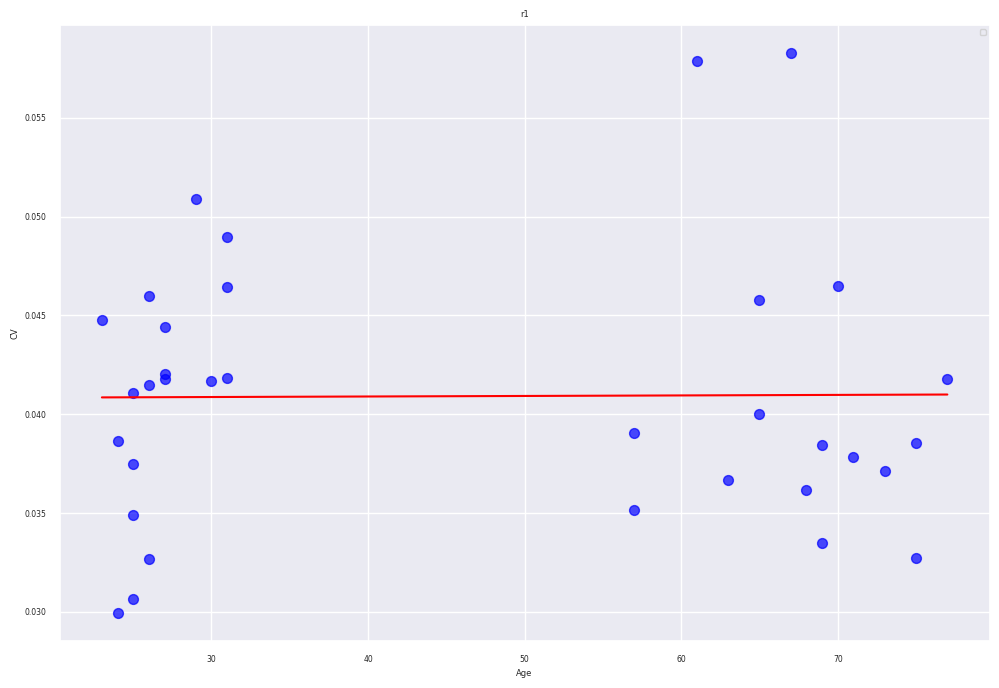

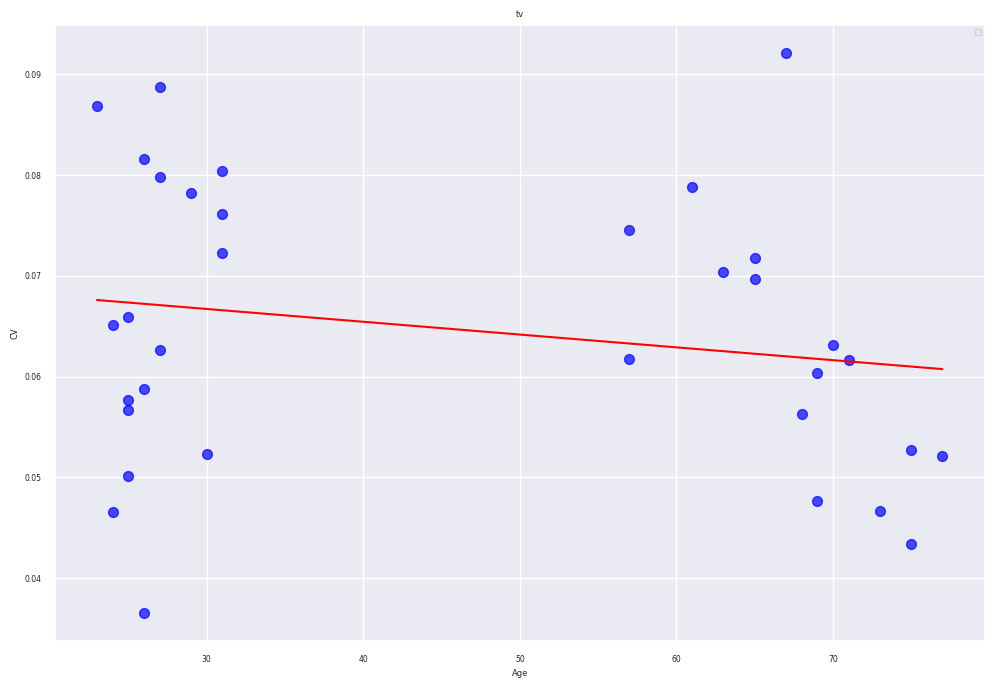

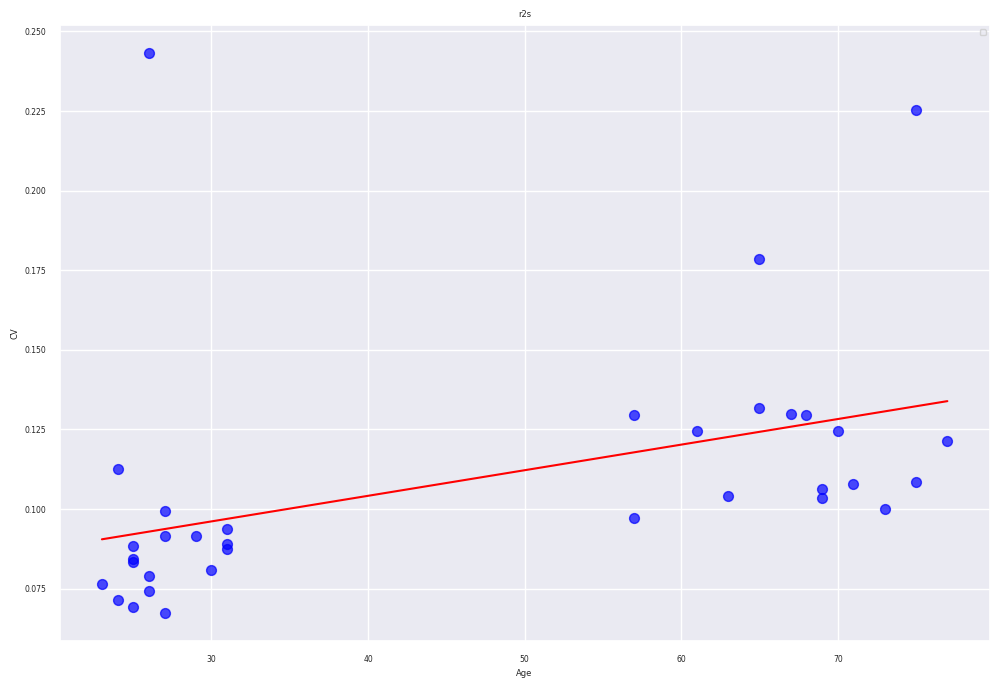

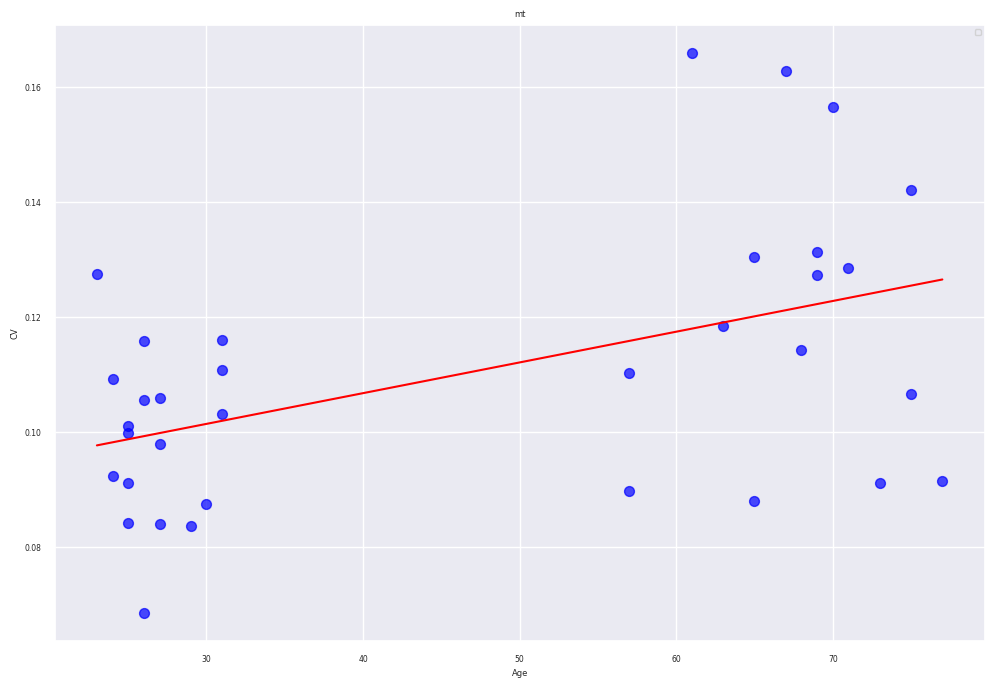

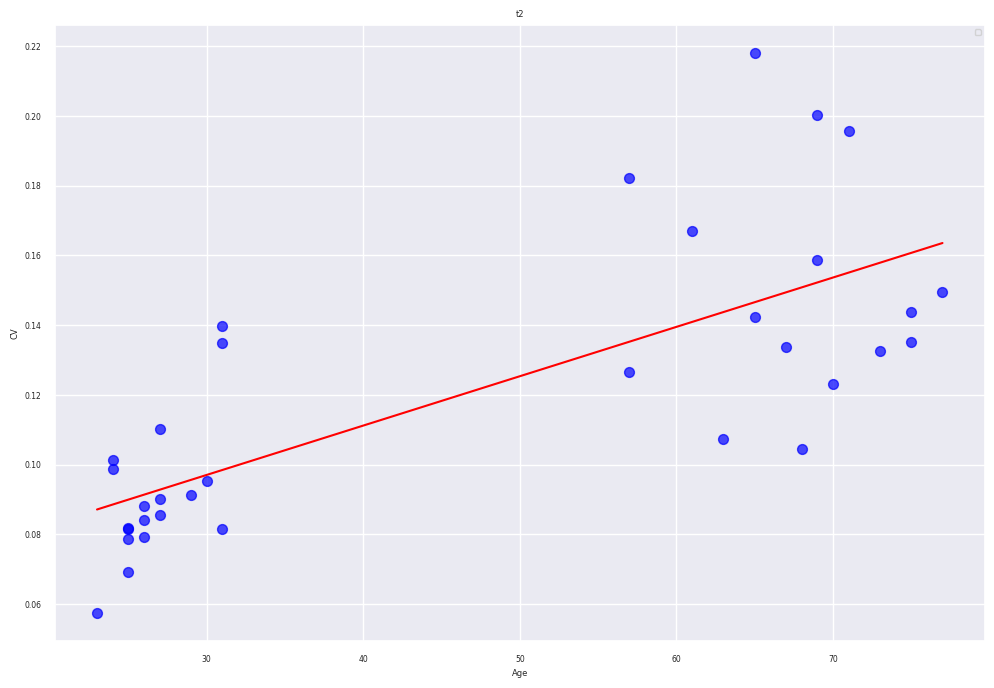

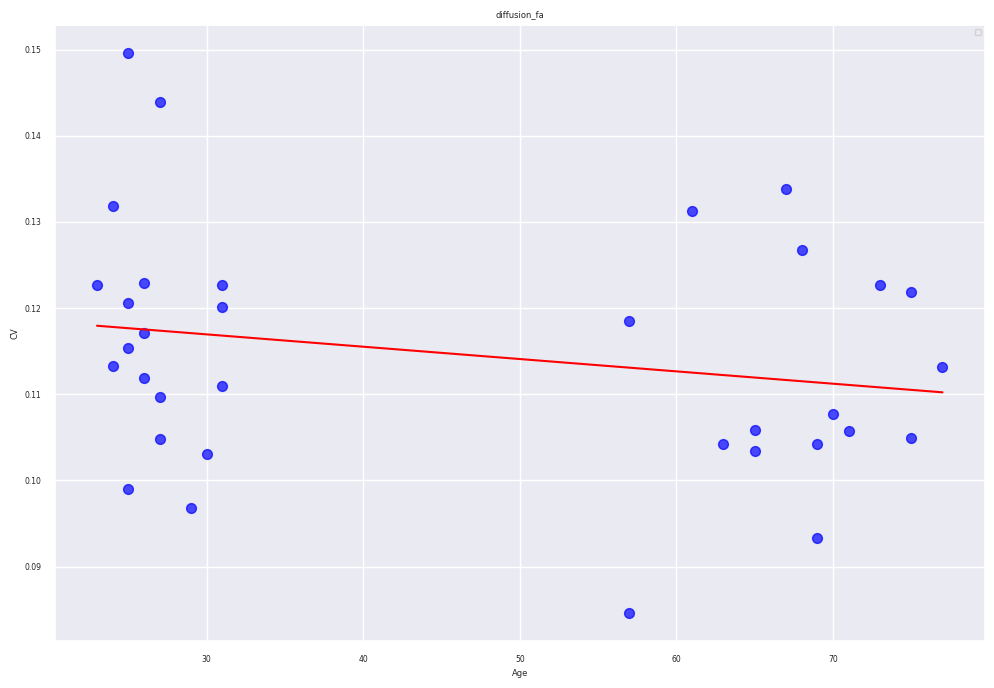

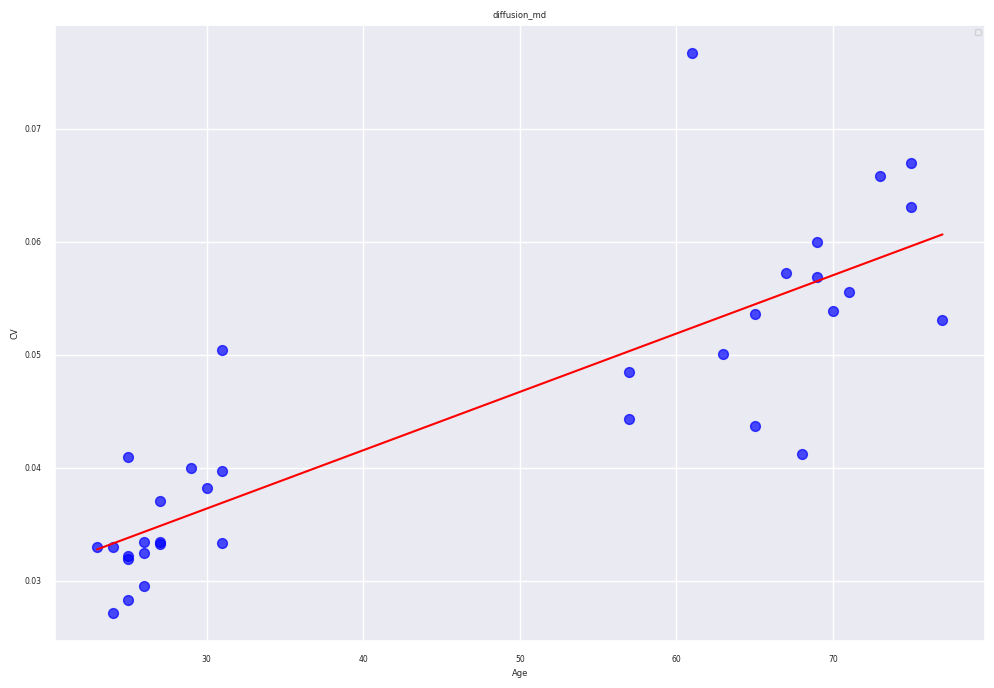

In [37]:
%autoreload 2
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data_raw, 'blue', '')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

Check correlations on the normalized data

In [47]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)

    young_std_result = StatisticsWrapper.roi_correlations_std(young_data, params_to_work_with, clusters_rois,
                                                        title='Stds of Correlations of young group', method=method)
    old_std_result = StatisticsWrapper.roi_correlations_std(old_data, params_to_work_with, clusters_rois,
                                                             title='Stds of Correlations of old group', method=method)

    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)
    show_corr_mean(young_result, old_result, clusters_rois)

def show_corr_mean(young_result, old_result, clusters_rois):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Average correlations')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    ax.plot(clusters_rois, young_result['corr_mean'].to_numpy())
    ax.plot(clusters_rois, old_result['corr_mean'].to_numpy())
    ax.legend()
    ax.set_facecolor('white')


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:529: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


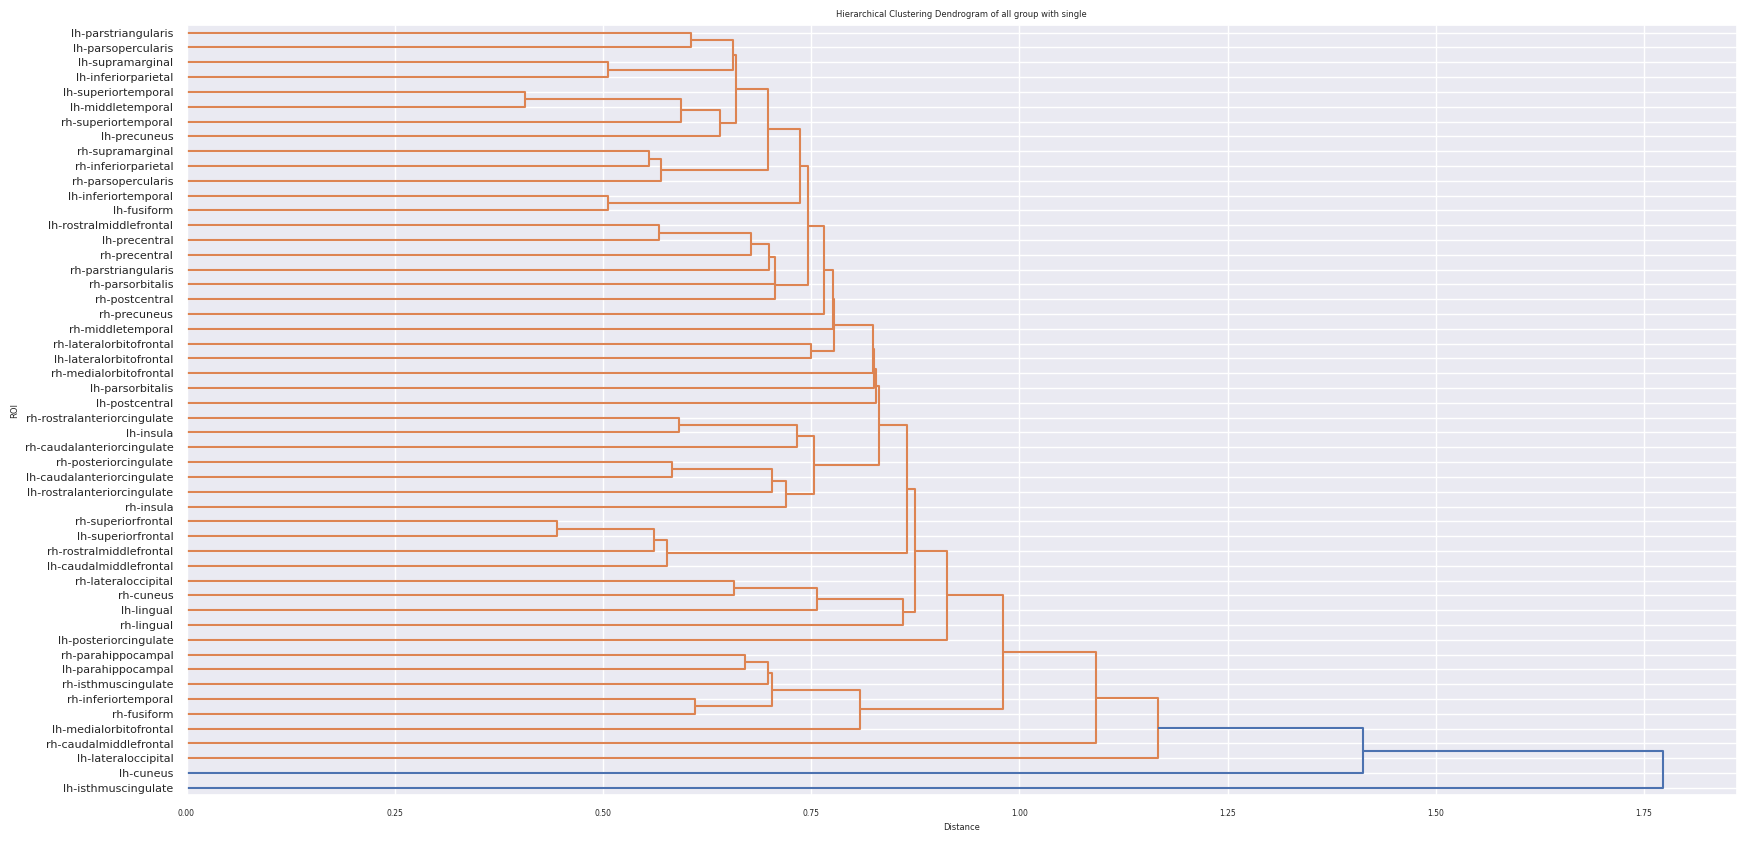

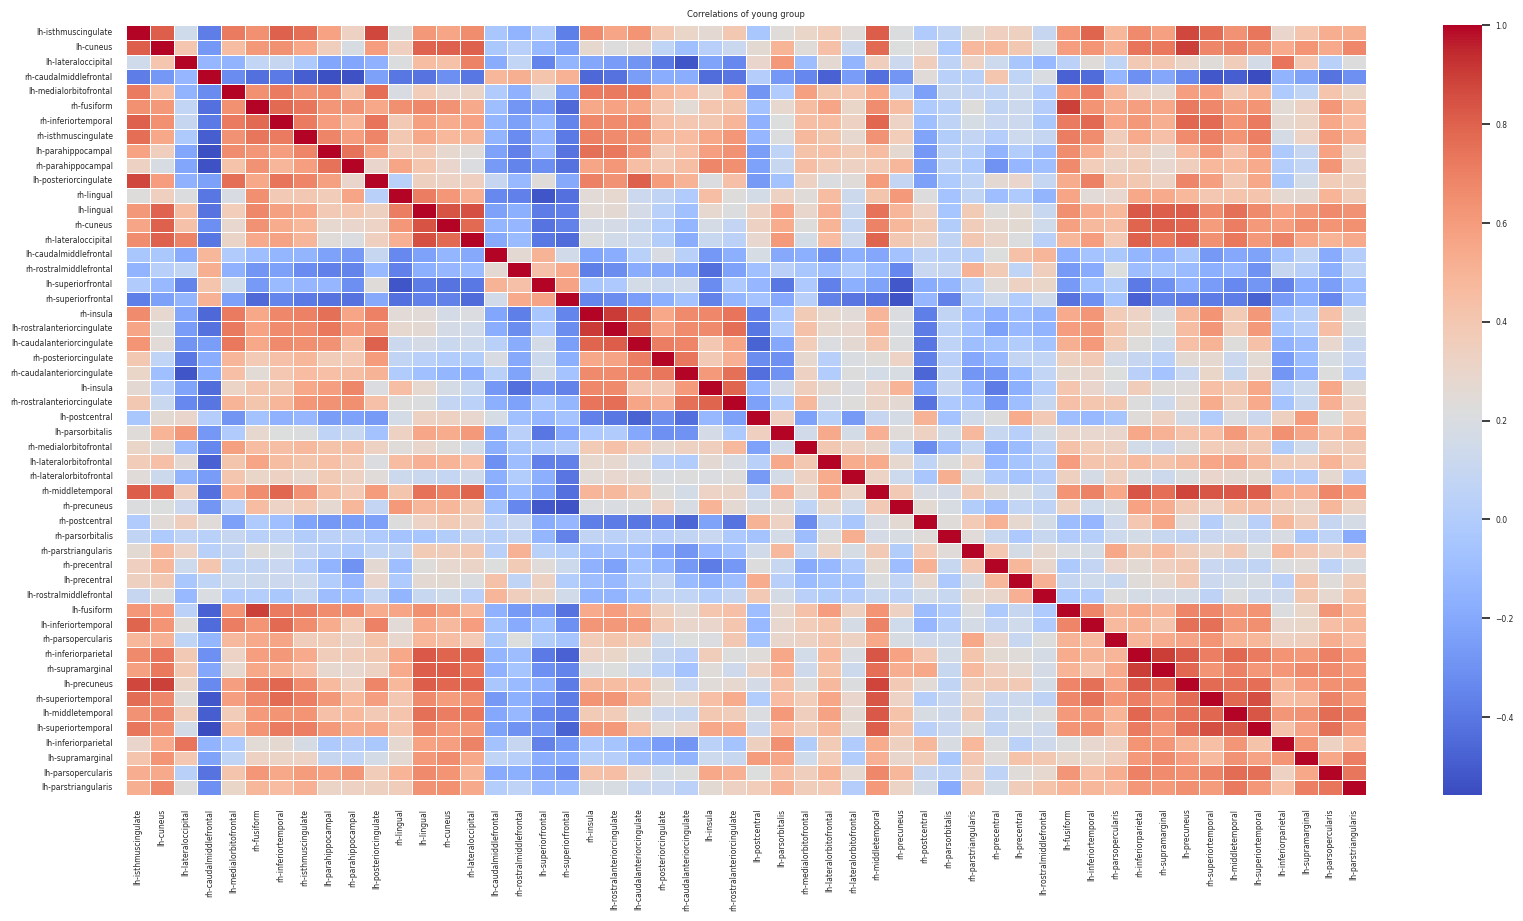

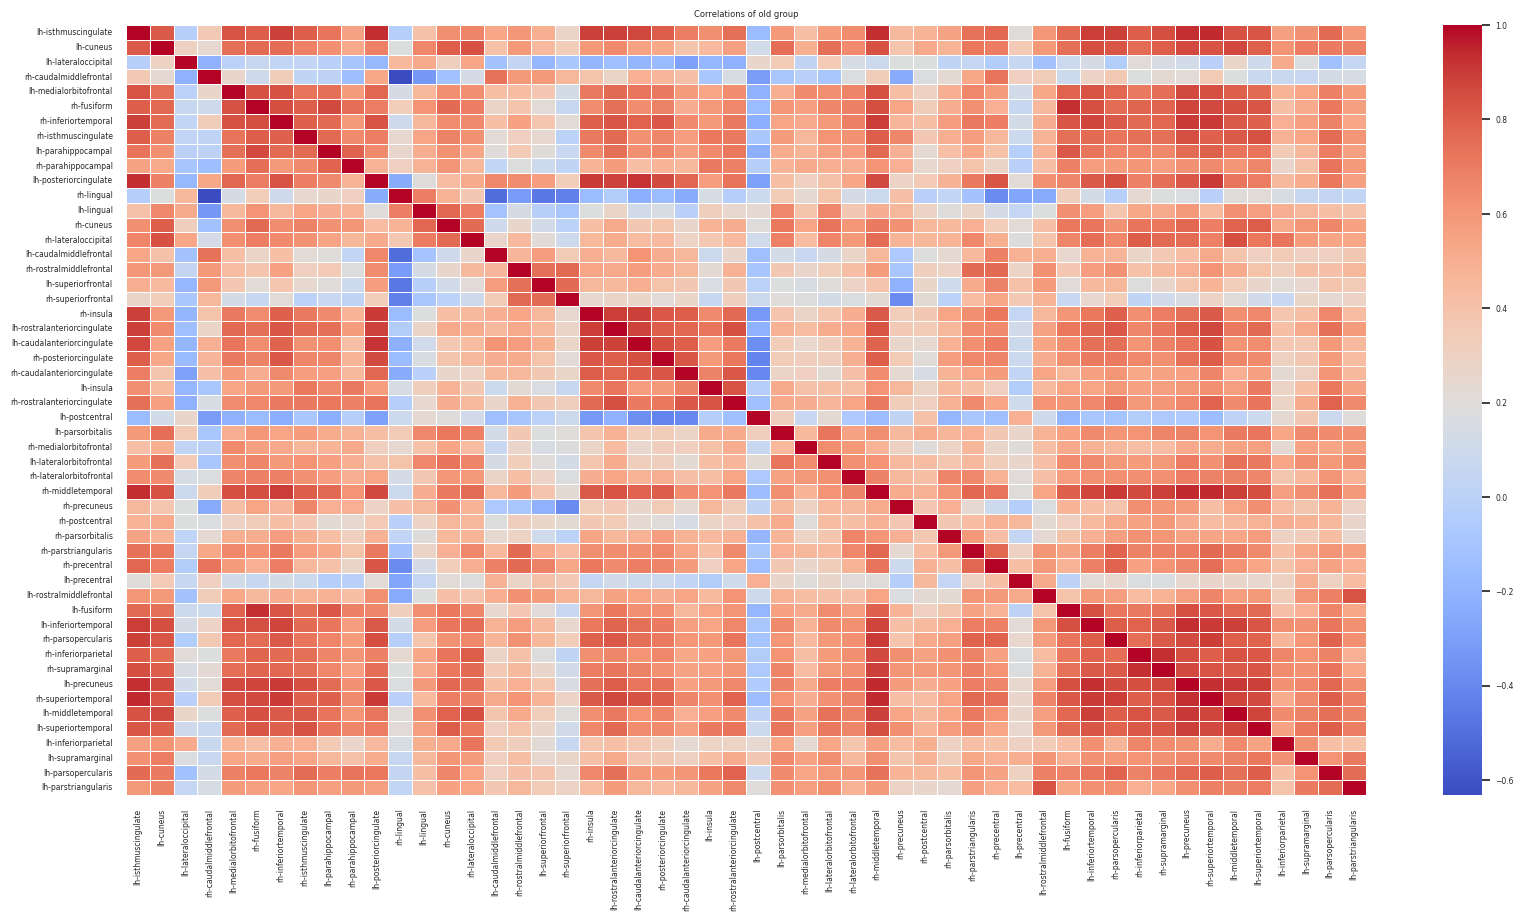

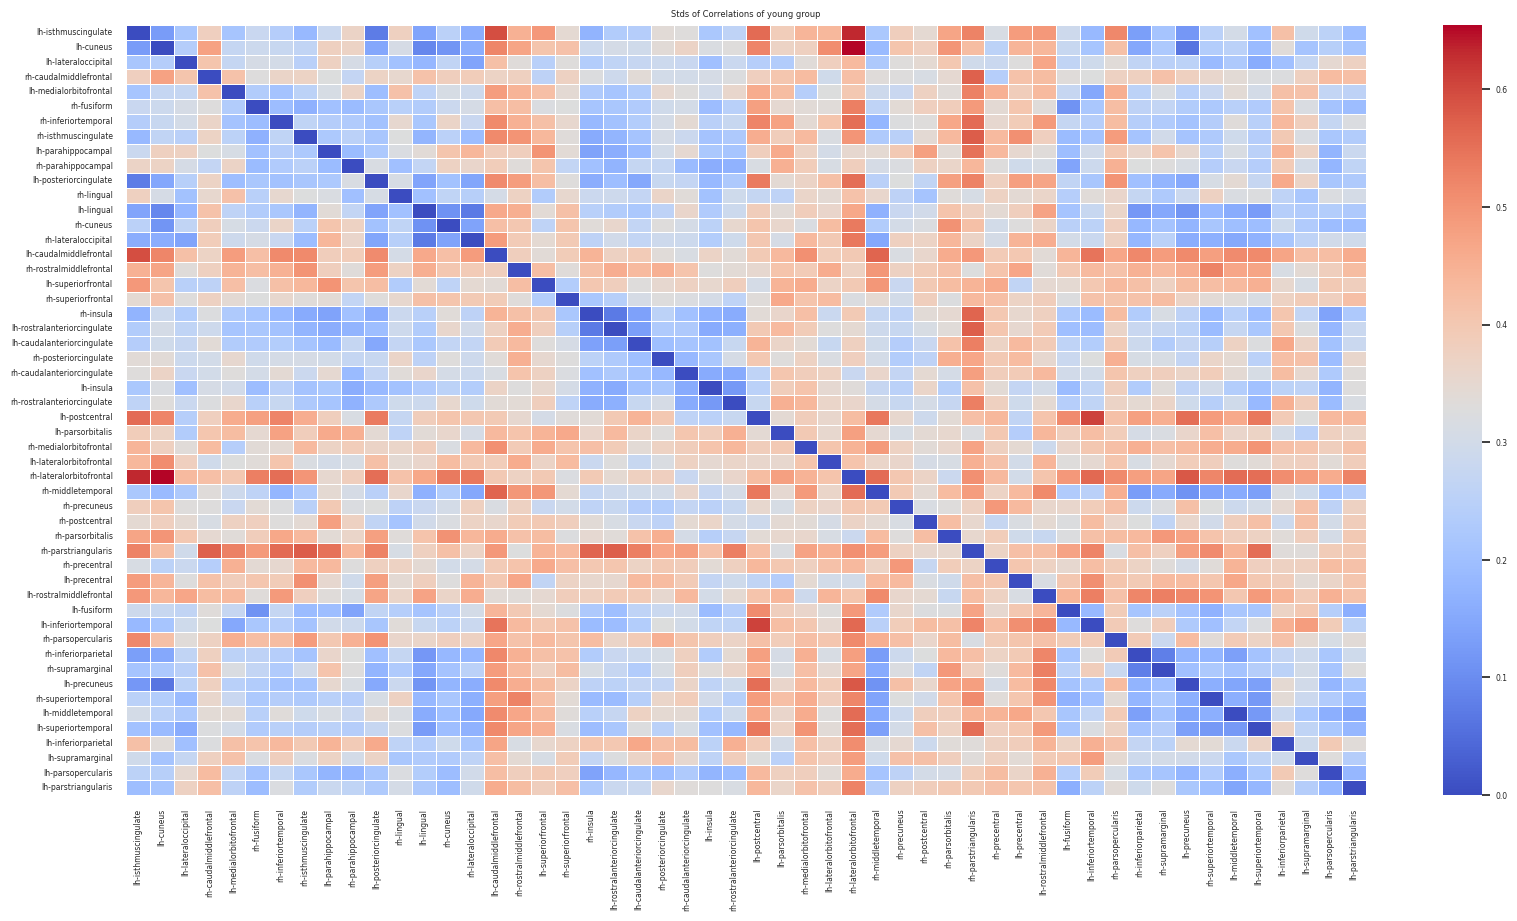

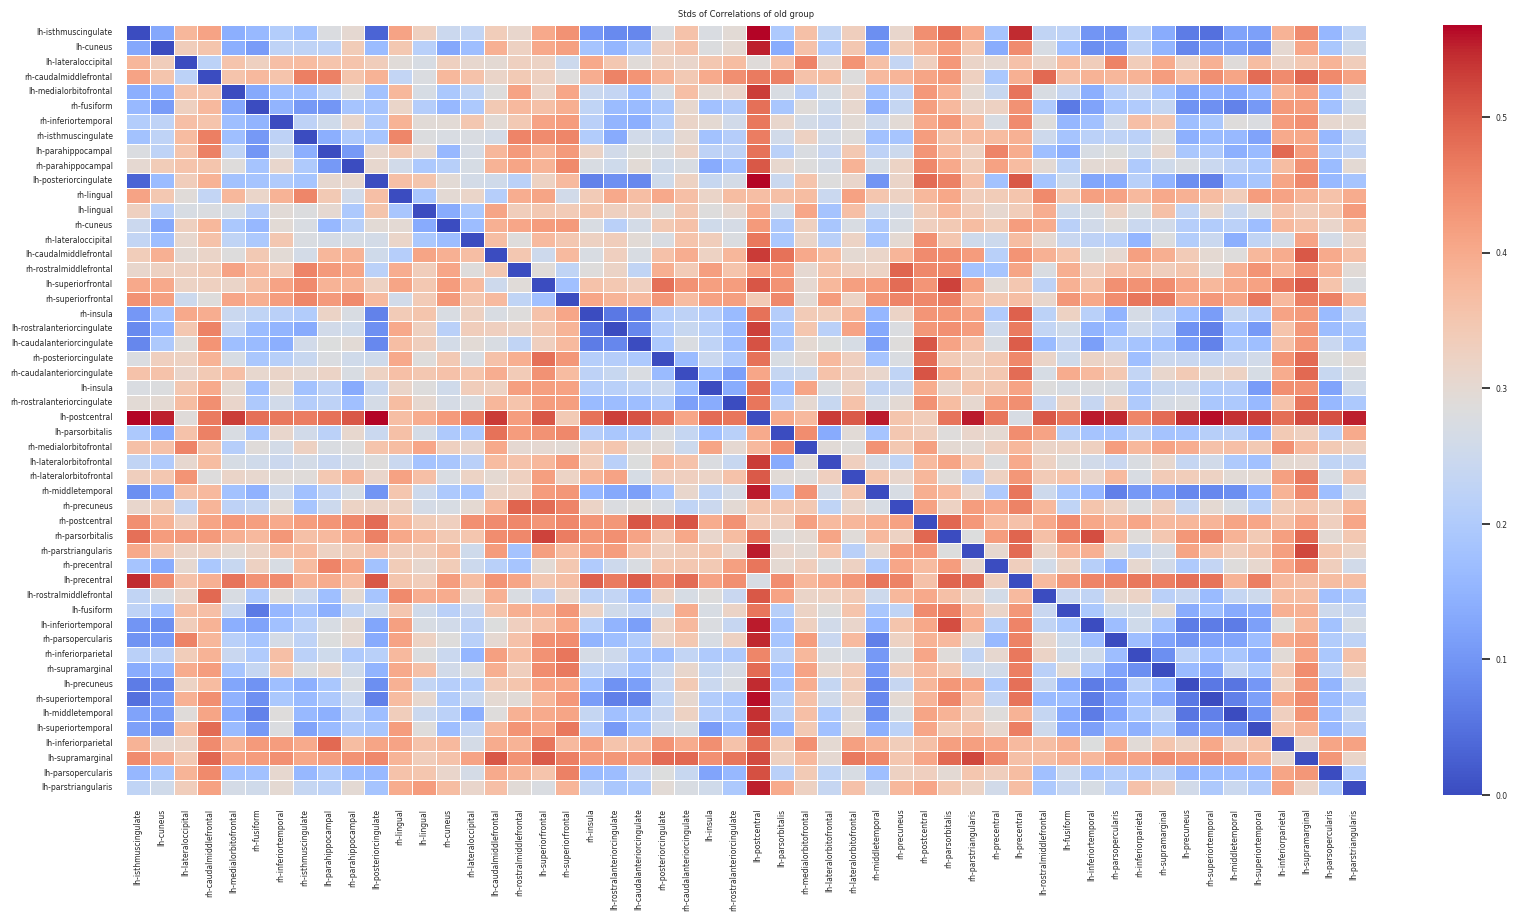

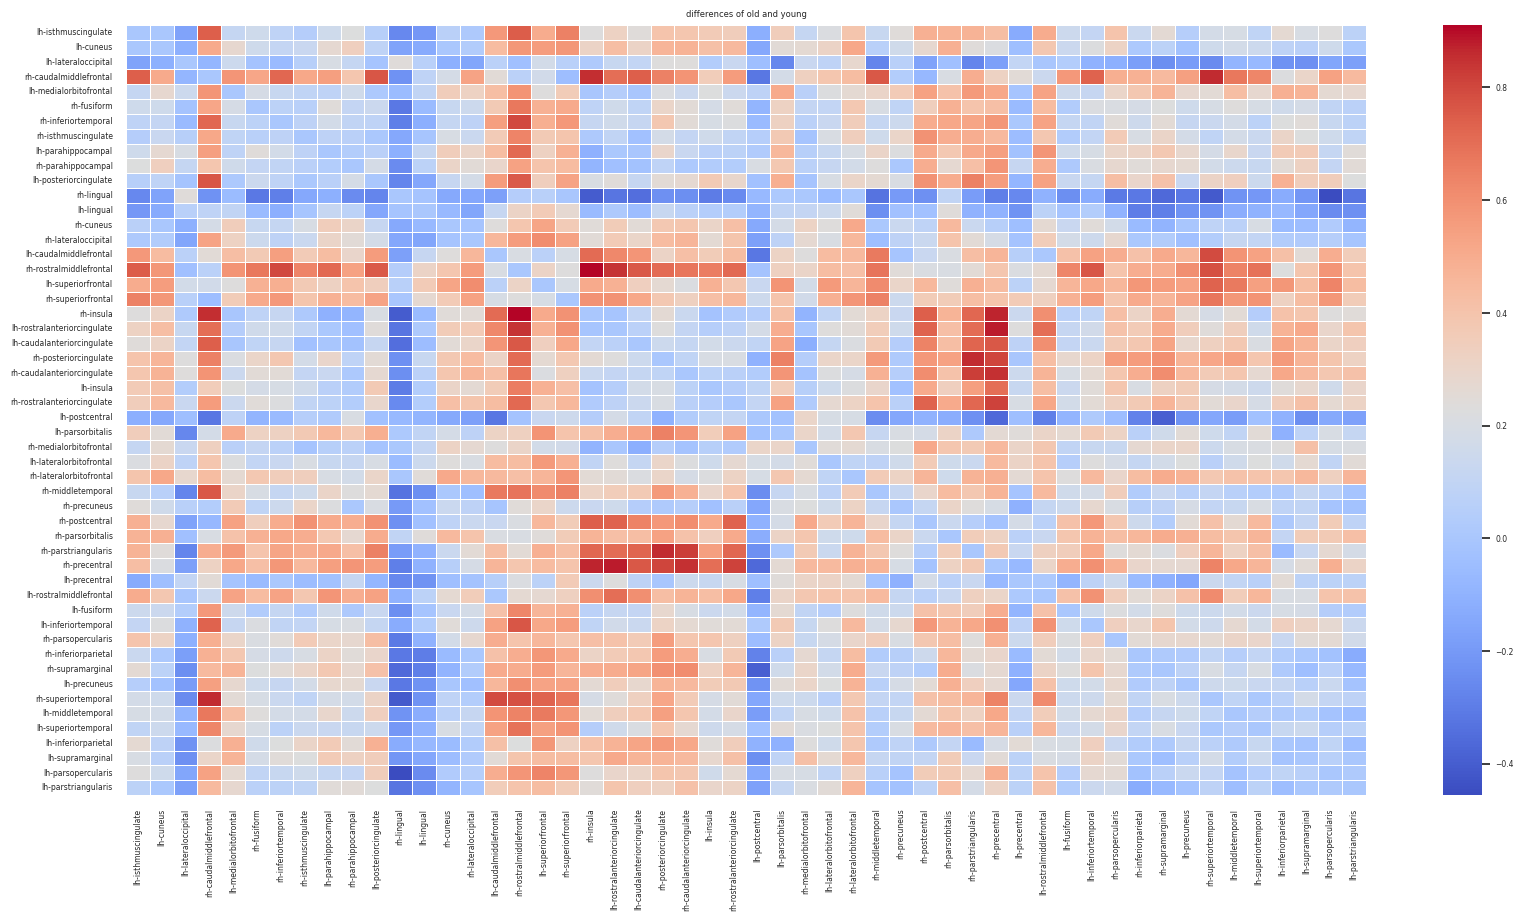

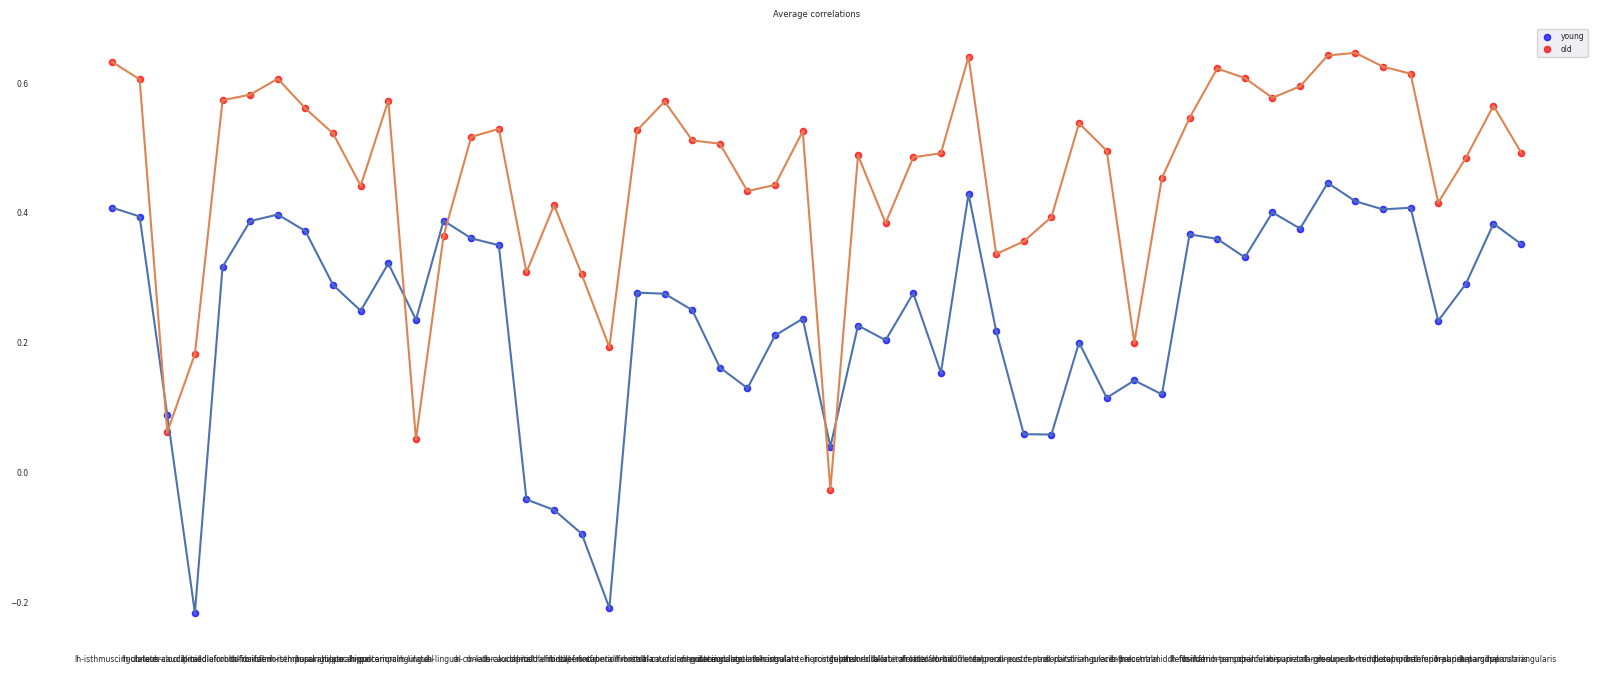

In [48]:
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'spearman')

Check t_test on the young and old groups

In [16]:
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 38
param tv number of areas with significance differences: 19
param r2s number of areas with significance differences: 18
param mt number of areas with significance differences: 24
param t2 number of areas with significance differences: 29
param diffusion_fa number of areas with significance differences: 21
param diffusion_md number of areas with significance differences: 29


Subjects clustering 

In [29]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(data.drop(columns='label'))  

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [30]:
young_features_df = pd.pivot_table(young_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(old_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

young_mask = young_features_df.index
old_mask = old_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[young_mask, 'label'] = 'young'
data_features_df.loc[old_mask, 'label'] = 'old'

In [31]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

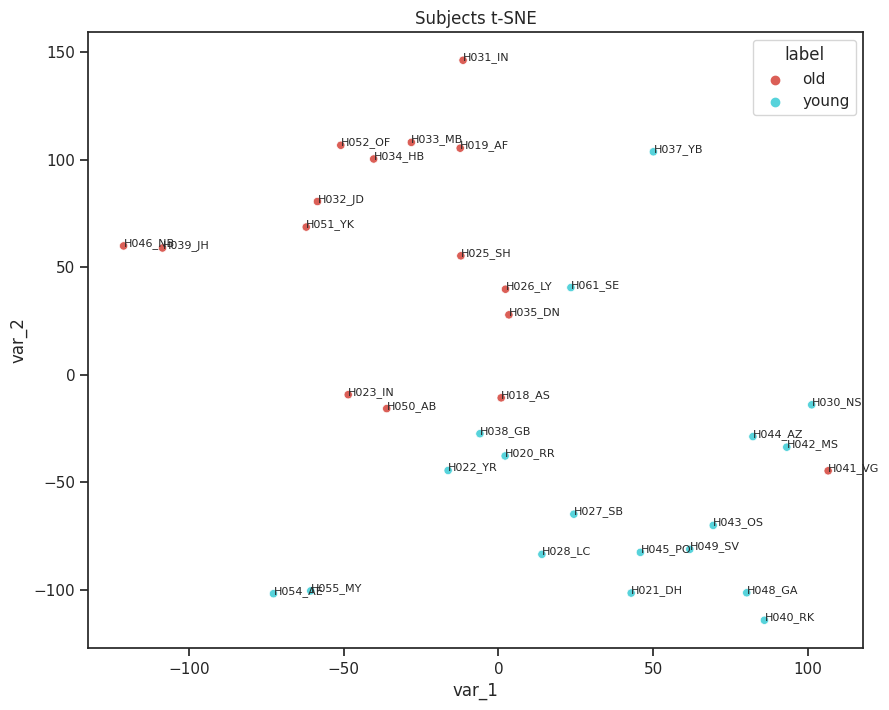

In [33]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_tsne,
    legend="full",
    ax=ax
    ).set_title('Subjects t-SNE')

for i, txt in enumerate(data_reduced_tsne.index):
    ax.annotate(txt, (data_reduced_tsne['var_1'][i], data_reduced_tsne['var_2'][i]), fontsize=8)


In [40]:
%load_ext autoreload
%autoreload 2
DataProcessor.outliers_counter(chosen_data_raw, params_to_work_with, chosen_rois_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
outliers counter: {'H023_IN': 7, 'H021_DH': 2, 'H046_NB': 2, 'H039_JH': 2, 'H037_YB': 2, 'H031_IN': 2, 'H041_VG': 1, 'H051_YK': 1, 'H019_AF': 1, 'H054_AE': 1, 'H025_SH': 1, 'H052_OF': 1, 'H034_HB': 1, 'H032_JD': 1, 'H050_AB': 1}


In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=config.seed)
        data_reduced_tsne = reduce_dim(tsne, data_features_df)

        young_df_tsne = data_reduced_tsne.loc[young_features_df.index]
        old_df_tsne = data_reduced_tsne.loc[old_features_df.index]

        fig, ax = plt.subplots(figsize=(10,8))
        ax.scatter(young_df_tsne['var_1'], young_df_tsne['var_2'], color='blue', label='young')
        ax.scatter(old_df_tsne['var_1'], old_df_tsne['var_2'], color='red', label='old')

        for i, txt in enumerate(young_df_tsne.index):
            ax.annotate(txt, (young_df_tsne['var_1'][i], young_df_tsne['var_2'][i]), fontsize=8)

        for i, txt in enumerate(old_df_tsne.index):
            ax.annotate(txt, (old_df_tsne['var_1'][i], old_df_tsne['var_2'][i]), fontsize=8) 

        plt.legend()
        plt.title(f'Subjects t-SNE perplexity {config.perplexity}')
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": list(range(2, 5))},
        "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_no_outliers")
wandb.agent(sweep_id, function=tsne_cluster)

Rois clustering

In [29]:
all_features_df = chosen_data_z_score[params_to_work_with]

young_mask = young_subjects_z_score.index
old_mask = old_subjects_z_score.index

# Assign labels directly to DataFrame
all_features_df.loc[young_mask, 'label'] = 'young'
all_features_df.loc[old_mask, 'label'] = 'old'

/tmp/ipykernel_1050755/490072393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_df.loc[young_mask, 'label'] = 'young'


In [45]:
model = TSNE(n_components=2, perplexity=30, random_state=42)
# model = PCA(n_components=2)
all_df_reduced = reduce_dim(model, all_features_df)

young_df_reduced = all_df_reduced.loc[young_features_df.index]
old_df_reduced = all_df_reduced.loc[old_features_df.index]

In [40]:
def plot_clusters_of_rois(reduced_data, prev_data, title):

    hue = []

    for roi in prev_data['ROI_name']:
        for lobe, lobe_values in constants.LOBES.items():
            if roi in lobe_values:
                hue.append(lobe)


    fig = plt.figure(figsize=(15,8))

    sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=sns.color_palette("husl", len(constants.LOBES.keys())),
        data=reduced_data,
        legend="full",
        ).set_title(title)

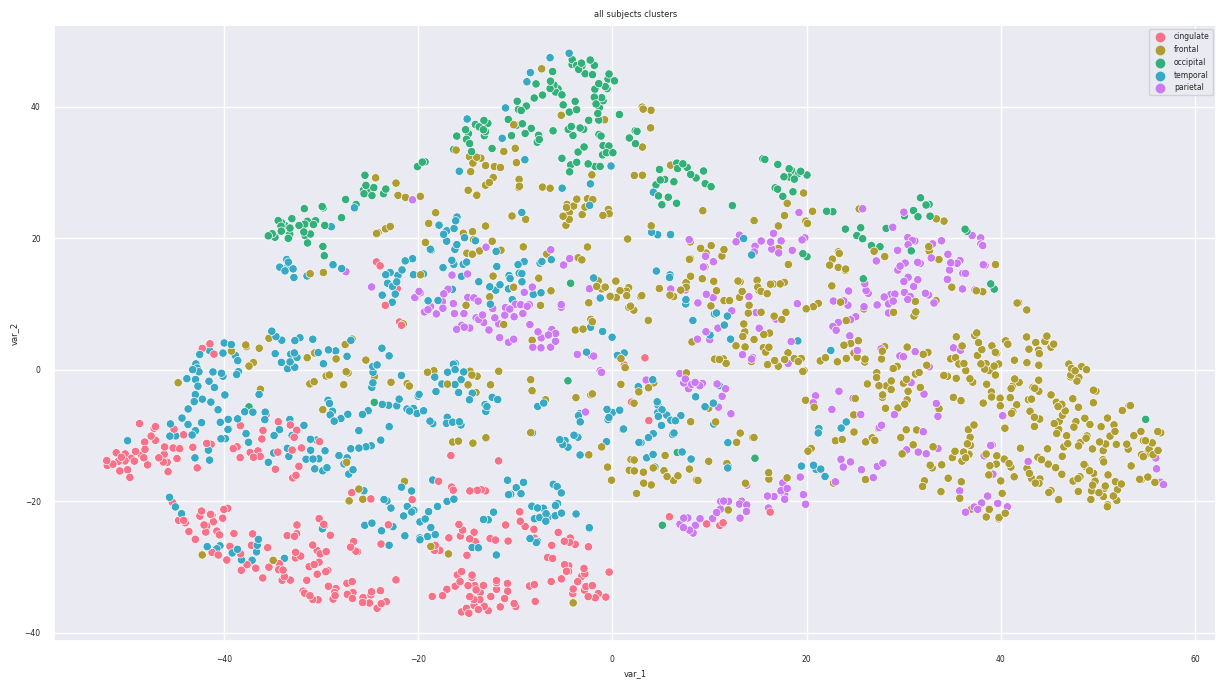

In [46]:
plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title="all subjects clusters")

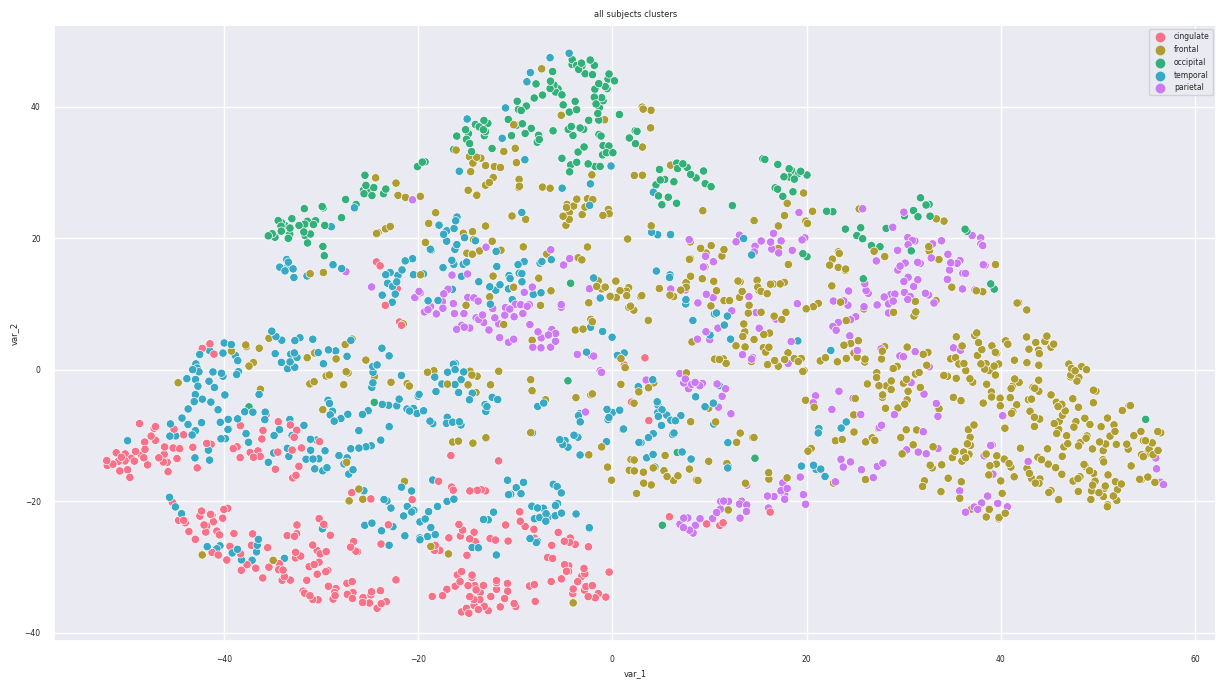

In [47]:
plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title="all subjects clusters")

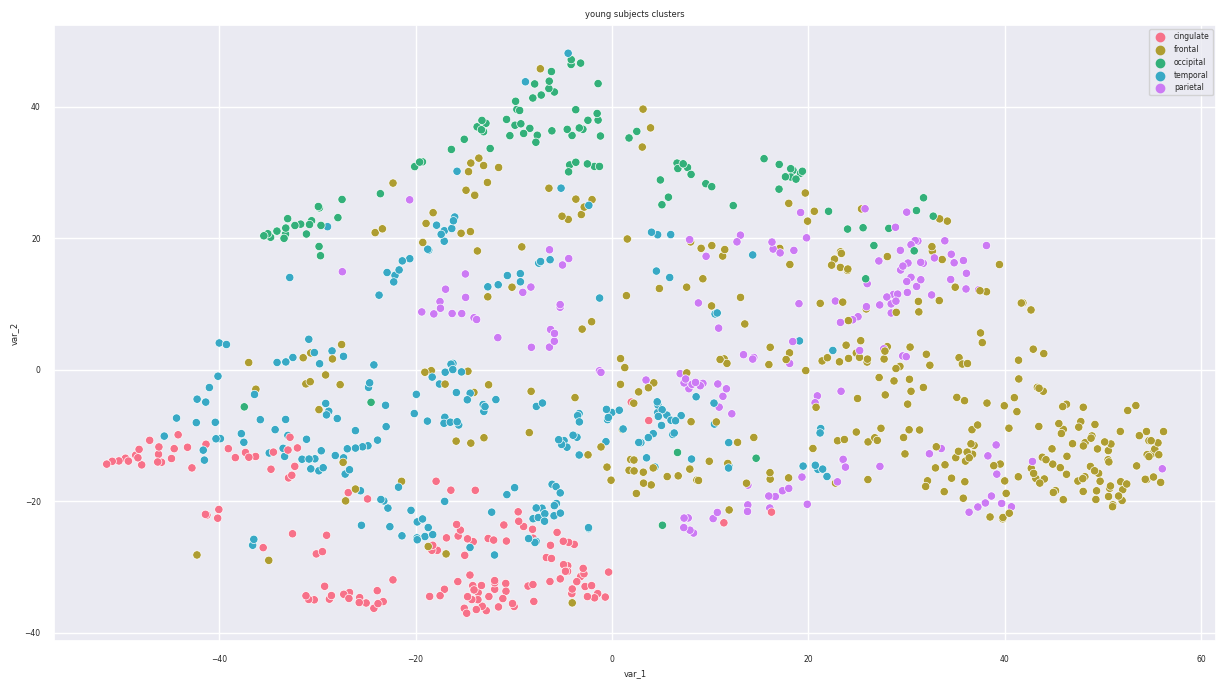

In [48]:
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'young'], young_subjects_z_score, title="young subjects clusters")

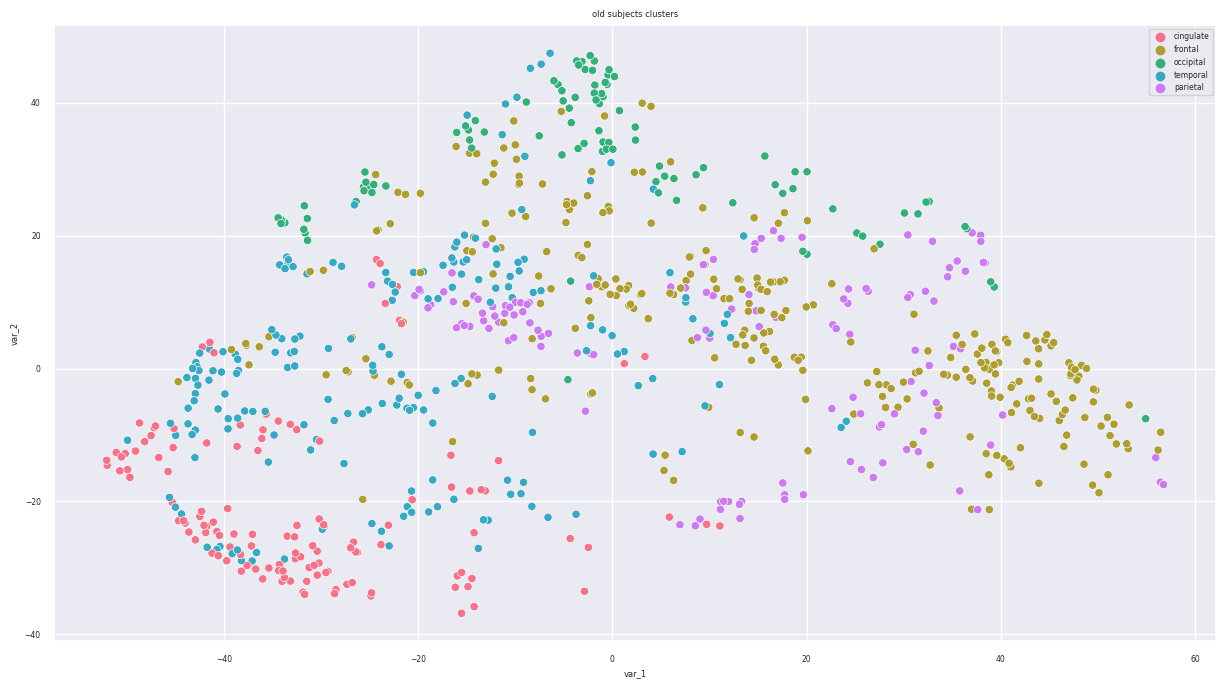

In [36]:
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'old'], old_subjects_z_score, title="old subjects clusters")

In [44]:
all_df_reduced.groupby('label').describe()

var_1                                                               
       count      mean       std       min       25%       50%       75%   
label                                                                      
old    832.0 -0.070633  0.388679 -1.220295 -0.330355 -0.070011  0.214216  \
young  936.0  0.062785  0.387701 -1.117997 -0.206130  0.071484  0.325340   

                 var_2                                                     
            max  count      mean       std       min       25%       50%   
label                                                                      
old    1.035823  832.0 -0.005110  0.217446 -0.540490 -0.138068 -0.014017  \
young  1.231804  936.0  0.004542  0.194737 -0.520456 -0.123661  0.004104   

                           
            75%       max  
label                      
old    0.128102  0.754286  
young  0.124323  0.600012

In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=42)
        all_df_reduced = reduce_dim(tsne, all_features_df)

        plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title=f"subjects clusters with perplexity {config.perplexity}")
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
        # "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_rois_clustering")
wandb.agent(sweep_id, function=tsne_cluster)